<a href="https://colab.research.google.com/github/rohandawar/-daysforcoding/blob/main/Text_Extraction_From_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook, I am trying to extract text from a image uaing python Tesseract Library.

The following actions would be performed in this notebook.

1. Install Testseract Library
2. Get/load the Data (Image from which Data needs to be extracted) 




In [16]:
from IPython.display import clear_output

In [17]:
!pip install pytesseract
clear_output()

In [18]:
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev
clear_output()

In [19]:
# Import Libs
from PIL import Image
import pytesseract
import cv2
import numpy as np
import re
import requests
from pytesseract import Output

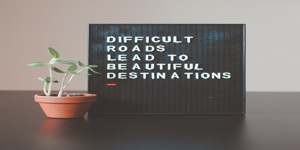

In [20]:
# Read the image from URL
image = Image.open(requests.get('https://source.unsplash.com/z1d-LP8sjuI', stream=True).raw)
image = image.resize((300,150))
image.save('sample.png')
image

In [21]:
# Simply extracting the text
custom_config = r'-l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image,config = custom_config)
print(text)

Tisai
ers

ea eed

ae eaeTs
ier

